In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from IPython.display import display
from scipy.special import expit, logit
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import scale

np.random.seed(1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Locating schools with a shortage of applicants

## Objective

Here is a quote from Max Brawer, researcher who works along with PASSNYC:

> "Only a third (roughly) of eligible students take the SHSAT, and our goal is to drive more test takers (you can't get in if you don't sit for the test!)."

It briefly summarizes main objective of PASSNYC, that is, bringing new students into taking SHSAT.

But, where should PASSNYC put its efforts? In this notebook I make recommendations about this, indicating schools where the actual amount of SHSAT test takers was far below what would be from its students.

## Method

First, I create a model that predicts the percentage of SHSAT applicants of a school, given its distribution of grades on the New York State tests.

Based on this model, I make predictions (what would be expected for each school) and calculate the difference between the actual number of applicants and the expected number of applicants. This difference, called residuals, is a good estimate of the gap between the potential number of applicants in a school and its actual number of applicants.

In other words, we are locating schools that have capable students not applying for SHSAT.

## Model

The percentage of SHSAT takers of each school are estimated using a robust logit regression. Only schools with a known outcome are used to fit the parameters.

Also, inputs are preprocessed using PCA (Principal Component Analysis). I do so to remove redundancy from the model. The number of principal components is chosen using cross-validation.

## Data

The data used here follows a group of students that took the NYS tests and SHSAT in 2017.

Sources:
- https://infohub.nyced.org/reports-and-policies/citywide-information-and-data/test-results
- https://data.cityofnewyork.us/Education/2017-2018-SHSAT-Admissions-Test-Offers-By-Sending-/vsgi-eeb5/

# Prepare the data

In [2]:
# load
df = pd.read_pickle('../data/process/schools2017.pkl')

# select columns
df = df[[        
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
    
    '# Students in HS Admissions',
    '# SHSAT Testers',
    '% SHSAT Testers',
]].copy()
print(df.shape[0], "schools")

# drop schools with missing test data
df = df[df.loc[:, 'Mean Scale Score - ELA':'% Level 4 - Math'].notnull().all(axis=1)]
print(df.shape[0], "schools after dropping missing test data")

# schools with 0-5 SHSAT testers have this value set to NaN
applicantsok = df['# SHSAT Testers'].notnull()

# convert percentages to the (0, 1) range
bad_pct_c = [
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]
df.loc[:, bad_pct_c] = df.loc[:, bad_pct_c] / 100.0

# standardize score columns (algorithm stability)
score_c = ['Mean Scale Score - ELA', 'Mean Scale Score - Math']
df.loc[:, score_c] = df.loc[:, score_c].apply(scale)

594 schools
588 schools after dropping missing test data


# Choose the PCA parameter

## Prepare dataset

The grades columns are chosen and the output is transformed into logit.

In [3]:
in_columns = [
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math', 
]
inputs = df[applicantsok][in_columns]
outputs = logit(df[applicantsok]['% SHSAT Testers'])

In [4]:
inputs.sample(3, random_state=1)

,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math
DBN,,,,,,,,
09X231,-1.227951,0.500000,0.125000,0.000000,-0.859372,0.319149,0.085106,0.0000
19K218,-1.187751,0.309091,0.181818,0.063636,-0.840951,0.232143,0.142857,0.0625
25Q294,1.506860,0.153846,0.400000,0.384615,1.291700,0.203125,0.328125,0.3750


In [5]:
outputs.sample(3, random_state=1)

DBN
09X231   -2.005334
19K218   -1.660296
25Q294    0.000000
Name: % SHSAT Testers, dtype: float64

## Cross-validate

I use a repeated k-fold<sup> <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html#sklearn.model_selection.RepeatedKFold">[1]</a></sup> here.

<sub>When the MAD (median absolute deviation) abbreviation is used, I am, instead, refering to the Median Absolute Error.</sub>

In [6]:
# cross-validation

cv_results = []
n_splits = 10
n_repeats = 20
for n_components in range(1, inputs.shape[1] + 1):
    mad_scores = []
    mse_scores = []
    
    x = PCA(n_components).fit_transform(inputs)
    x = pd.DataFrame(x, index=inputs.index, columns=["PC{}".format(i) for i in range(1, n_components + 1)])
    x['Constant'] = 1
    y = outputs.copy()
    

    cv = RepeatedKFold(n_splits, n_repeats, random_state=1)    
    for train, test in cv.split(x):
        x_train = x.iloc[train]
        x_test = x.iloc[test]
        y_train = y.iloc[train]
        y_test = y.iloc[test]
        
        model = sm.RLM(y_train, x_train, M=sm.robust.norms.HuberT())
        results = model.fit()
        predictions = model.predict(results.params, exog=x_test)
        mad = median_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mad_scores.append(mad)
        mse_scores.append(mse)
        
    mad_scores = np.array(mad_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
    mse_scores = np.array(mse_scores).reshape(n_repeats, n_splits).mean(axis=1)  # mean of each repeat
        
    mad_mean = np.mean(mad_scores)
    mad_std = np.std(mad_scores)
    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    
    cv_result = (n_components, mad_mean, mse_mean, mad_std, mse_std)
    cv_results.append(cv_result)
    
df_columns = ['n_components', 'mad__mean', 'mse__mean', 'mad__std', 'mse__std']
cv_results_df = pd.DataFrame(cv_results, columns=df_columns)
cvdf = cv_results_df
cvdf

,n_components,mad__mean,mse__mean,mad__std,mse__std
0,1,0.411165,0.506727,0.007764,0.001461
1,2,0.413455,0.508851,0.008379,0.001686
2,3,0.411420,0.486117,0.006278,0.001801
3,4,0.403242,0.488352,0.005524,0.001855
4,5,0.409502,0.489757,0.006140,0.002181
5,6,0.412552,0.492288,0.005801,0.002200
6,7,0.415058,0.493185,0.005356,0.002643
7,8,0.416387,0.495168,0.005676,0.002533


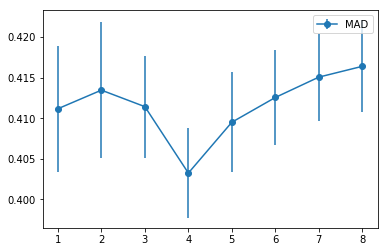

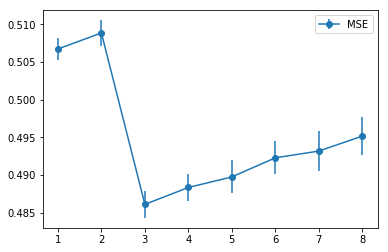

In [7]:
# visualize results

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mad__mean, cvdf.mad__std, marker='o', label='MAD')
plt.legend()

plt.figure()
plt.errorbar(cvdf.n_components, cvdf.mse__mean, cvdf.mse__std, marker='o', label='MSE')
plt.legend();

When using 4 principal components, we produce the best results in the middle range and not the best, but good results for extreme values (outliers).

Since we want to fit well in the middle, and not so well in extreme regions (so that outliers become visible), we will choose this value.

# Create the model

We will use a robust linear regression over the logits.

First, the robust regression makes the model more insensitive to outliers (but improves outlier detection in the predictions).<sup> 1</sup>

Secondly, we transform the output probabilities to logits, making the model essentially a [logit regression][1].

<sub>1: The objective of the analysis is not exactly outlier detection, but could be expressed as so: we want to find schools whose rates of applicants are *far away* from what would be expected given their students scores.</sub>
    
[1]: https://en.wikipedia.org/wiki/Logistic_regression

## Transform the inputs

In [8]:
base_df = df[[  # explanatory variables
    'Mean Scale Score - ELA',
    '% Level 2 - ELA',
    '% Level 3 - ELA',
    '% Level 4 - ELA',
    'Mean Scale Score - Math',
    '% Level 2 - Math',
    '% Level 3 - Math',
    '% Level 4 - Math',
]]

n_components = 4  # from the cross-validation
pca = PCA(n_components)
transformed = pca.fit_transform(base_df)
transformed = pd.DataFrame(transformed, index=base_df.index, columns=["PC{}".format(i+1) for i in range(n_components)])
transformed.head()

inputs = transformed
inputs.insert(0, 'Constant', 1.0)
inputs.head()

,Constant,PC1,PC2,PC3,PC4
DBN,,,,,
01M034,1.0,-1.032635,-0.084409,-0.071596,0.072216
01M140,1.0,-0.904256,0.118499,-0.094476,0.110161
01M184,1.0,2.126705,0.220717,0.160083,0.020316
01M188,1.0,-0.869363,0.309213,-0.062297,0.056750
01M301,1.0,-0.669184,-0.292745,-0.080625,-0.010970


## Fit/Predict

In [9]:
#data
inputs_fit = inputs[applicantsok]
outputs_fit = logit(df['% SHSAT Testers'][applicantsok])
inputs_predict = inputs

# fit
model = sm.RLM(outputs_fit, inputs_fit, M=sm.robust.norms.HuberT())
results = model.fit()

# predict
predictions = model.predict(results.params, exog=inputs_predict)
predictions = pd.Series(predictions, index=inputs_predict.index)
predictions.name = 'Predictions'

# score
mad = median_absolute_error(outputs_fit, predictions[applicantsok])
mse = mean_squared_error(outputs_fit, predictions[applicantsok])

In [10]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:        % SHSAT Testers   No. Observations:                  533
Model:                            RLM   Df Residuals:                      528
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 03 Aug 2018                                         
Time:                        19:44:02                                         
No. Iterations:                    20                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      -0.9031      0.026    -34.506      0.000      -0.954      -0.852
PC1            0.5465      0.019     29.101      0.000       0.510       0.583
PC2            0.0269      0.089      0.301      0.764      -0.148       0.202
PC3            0.9176      0.167      5.486      0.000       0.590       1.245
PC4           -0.2559      0.278     -0.920      0.358      -0.801       0.289
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

PC2 and PC4 have low statistical significance. This suggests a different model may provide better analysis.

We stick with what we have though.

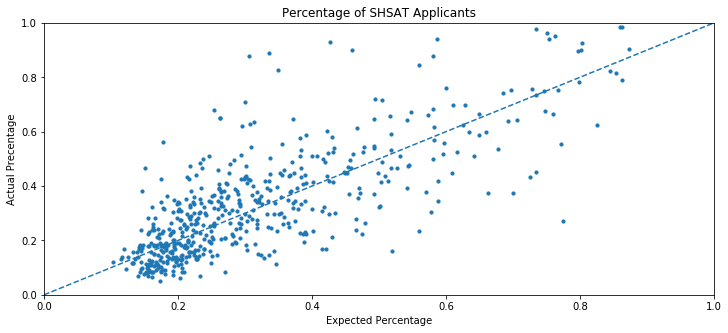

In [11]:
xs = expit(predictions[applicantsok])  # expit function is the inverse of the logit
ys = expit(outputs_fit)

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, s=10)
plt.plot([0, 1], [0, 1], '--')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Percentage of SHSAT Applicants")
plt.xlabel("Expected Percentage")
plt.ylabel("Actual Precentage");

# Arrange results

Here I arrange the results into a DataFrame that I believe is gonna be useful for PASSNYC.

Distinction between minimum and maximum values must be made because there are some schools for which we don't know the specific amount of SHSAT test takers.

In [12]:
def from_counts(shsat_counts, hs_counts):
    return pd.DataFrame({
        'logit': logit(shsat_counts / hs_counts),
        'pct': shsat_counts / hs_counts,
        'cnt': shsat_counts,
    })

def from_logits(shsat_logits, hs_counts):
    return pd.DataFrame({
        'logit': shsat_logits,
        'pct': expit(shsat_logits),
        'cnt': expit(shsat_logits) * hs_counts,
    })

In [13]:
# actual values  ---

# schools with 0 to 5 applicants
hs_counts = df[~applicantsok]['# Students in HS Admissions']
min_v = from_counts(0, hs_counts)
max_v = from_counts(5, hs_counts)

# schools with 6 or more applicants
shsat_counts = df[applicantsok]['# SHSAT Testers']
hs_counts = df[applicantsok]['# Students in HS Admissions']
pontual_v = from_counts(shsat_counts, hs_counts)


# expected values  ---

shsat_logits = predictions
hs_counts = df['# Students in HS Admissions']
expected_v = from_logits(shsat_logits, hs_counts)


# differences  ---

min_diff = (min_v - expected_v).dropna()
max_diff = (max_v - expected_v).dropna()
pontual_diff = (pontual_v - expected_v).dropna()


# join everything  ---

everything = pd.DataFrame({
    'Actual # (min)': pd.concat([min_v, pontual_v])['cnt'],
    'Actual # (max)': pd.concat([max_v, pontual_v])['cnt'],
    'Estimated #': expected_v['cnt'],
    'Difference # (min)': pd.concat([min_diff, pontual_diff])['cnt'],
    'Difference # (max)': pd.concat([max_diff, pontual_diff])['cnt'],
            
    'Actual % (min)': pd.concat([min_v, pontual_v])['pct'],
    'Actual % (max)': pd.concat([max_v, pontual_v])['pct'],
    'Estimated %': expected_v['pct'],
    'Difference % (min)': pd.concat([min_diff, pontual_diff])['pct'],
    'Difference % (max)': pd.concat([max_diff, pontual_diff])['pct'],    
            
    'Chance Multiplier': np.exp(pd.concat([max_diff, pontual_diff])['logit']),  # note - using max diff
})
everything = everything.sort_index()
everything.head().style. \
    format('{:.0f}', subset=pd.IndexSlice[:, 'Actual # (min)':'Difference # (max)']). \
    format('{:.0%}', subset=pd.IndexSlice[:, 'Actual % (min)':'Difference % (max)']). \
    format('{:.2f}', subset=['Chance Multiplier'])

,Actual # (min),Actual # (max),Estimated #,Difference # (min),Difference # (max),Actual % (min),Actual % (max),Estimated %,Difference % (min),Difference % (max),Chance Multiplier
01M034,6,6,10,-4,-4,10%,10%,17%,-7%,-7%,0.55
01M140,6,6,12,-6,-6,9%,9%,18%,-9%,-9%,0.44
01M184,67,67,53,14,14,76%,76%,60%,16%,16%,2.12
01M188,0,5,11,-11,-6,0%,8%,19%,-19%,-11%,0.39
01M301,11,11,11,0,0,22%,22%,21%,1%,1%,1.06


This table in itself is a nice deliverable to PASSNYC. It provides an estimate of the gap of applicants in each school, a strong indicator of where resources may be harnessed best.

A column worth mentioning is the *Chance Multiplier*. This value is equal to $\frac{\text{actual odds of applying}}{\text{estimated odds of applying}}$. As an example, if the *Chance Multiplier* of a school is equal to 2.0, then, its students have roughly double the chance of applying (compared to what was estimated).

# Example usage of the table

In [56]:
# load dataframes
# 'vis' are those that are easier to visualize

schools = pd.read_pickle('../data/process/schools2017.pkl')
schools = schools[schools.loc[:, 'Mean Scale Score - ELA':'% Level 4 - Math'].notnull().all(axis=1)]  # drop na
score_c = ['Mean Scale Score - ELA', 'Mean Scale Score - Math']
schools.loc[:, score_c] = schools.loc[:, score_c].apply(scale)  # standardize columns

schools_vis = pd.read_pickle('../data/output/schools2017_vis.pkl')
results_vis = pd.read_pickle('../data/output/model1_results_vis.pkl')
vis = schools_vis.join(results_vis, how='inner')
vis.sample(random_state=1)

,School Name,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %,Chance Multiplier
84K730,Summit Academy Charter School,Brooklyn,40.68,-74.01,0%,31%,66%,2%,1%,12%,23%,32%,88%,-0.32,51%,30%,3%,0.05,45%,18%,8%,47,7,11,-4,15%,24%,-9%,0.56


For example, let's say we want to find the schools which have biggest number of possible converts (students who didn't take the SHSAT but were expected to take).

We first create a index and then, order the table with it:

In [57]:
index = everything.sort_values('Difference # (min)').index
vis.reindex(index).head()

,School Name,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %,Chance Multiplier
31R034,I.S. 034 Tottenville,Staten Island,40.51,-74.24,4%,0%,11%,85%,1%,2%,27%,21%,22%,0.74,33%,39%,19%,0.92,29%,34%,22%,378,81,162,-81,21%,43%,-22%,0.36
24Q061,I.S. 061 Leonardo Da Vinci,Queens,40.74,-73.86,6%,3%,89%,2%,0%,31%,19%,15%,70%,-0.36,48%,26%,5%,-0.23,39%,18%,5%,716,93,163,-70,13%,23%,-10%,0.51
31R007,I.S. 007 Elias Bernstein,Staten Island,40.52,-74.19,5%,0%,7%,86%,1%,1%,17%,16%,20%,1.17,29%,41%,26%,1.18,28%,28%,31%,394,129,198,-69,33%,50%,-17%,0.48
27Q323,Scholars' Academy,Queens,40.58,-73.83,22%,15%,16%,45%,2%,0%,10%,3%,26%,2.44,6%,32%,62%,1.85,11%,40%,47%,231,104,170,-66,45%,73%,-28%,0.30
31R075,I.S. 075 Frank D. Paulo,Staten Island,40.54,-74.20,9%,2%,11%,77%,1%,2%,23%,15%,21%,1.15,27%,40%,27%,0.90,30%,29%,25%,431,153,202,-49,35%,47%,-11%,0.62


In this case, the results were not useful. We just found schools with lots of students or excellent performance.

However, a more realistic might work:

In [70]:
ratio = everything['Difference # (max)'] / everything['Actual # (max)']
vis['Ratio'] = ratio.apply(lambda x: "{:.2f}".format(x))

In [69]:
vis.reindex(ratio.index)

,School Name,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %,Chance Multiplier
01M034,P.S. 034 Franklin D. Roosevelt,Manhattan,40.73,-73.98,5%,30%,61%,3%,1%,8%,38%,30%,87%,-0.65,59%,22%,2%,-0.77,35%,13%,0%,58,6,10,-4,10%,17%,-7%,0.55
01M140,P.S. 140 Nathan Straus,Manhattan,40.72,-73.98,4%,12%,79%,3%,1%,12%,34%,40%,85%,-0.70,60%,22%,2%,-0.53,39%,14%,0%,67,6,12,-6,9%,18%,-9%,0.44
01M184,P.S. 184m Shuang Wen,Manhattan,40.71,-73.99,70%,4%,12%,8%,5%,17%,19%,4%,56%,1.30,21%,40%,35%,1.63,17%,29%,45%,88,67,53,14,76%,60%,16%,2.12
01M188,P.S. 188 The Island School,Manhattan,40.72,-73.98,2%,32%,62%,4%,0%,15%,33%,37%,94%,-0.81,45%,16%,2%,-0.39,46%,21%,0%,59,0 🠒 5,11,-11 🠒 -6,0% 🠒 8%,19%,-19% 🠒 -11%,0.39
01M301,"Technology, Arts, and Sciences Studio",Manhattan,40.73,-73.98,9%,32%,50%,6%,4%,5%,44%,38%,75%,-0.26,46%,32%,5%,-0.67,37%,12%,2%,51,11,11,0,22%,21%,1%,1.06
01M332,University Neighborhood Middle School,Manhattan,40.71,-73.99,9%,28%,57%,5%,1%,10%,47%,30%,81%,-0.75,46%,18%,8%,-0.96,31%,8%,3%,68,13,12,1,19%,18%,1%,1.06
01M378,School for Global Leaders,Manhattan,40.72,-73.99,15%,27%,55%,2%,1%,10%,36%,33%,76%,-0.71,43%,22%,4%,-0.18,41%,18%,4%,96,19,21,-2,20%,22%,-2%,0.90
01M450,East Side Community School,Manhattan,40.73,-73.98,10%,15%,55%,17%,3%,0%,34%,4%,58%,0.97,24%,46%,22%,0.60,36%,24%,18%,94,16,39,-23,17%,41%,-24%,0.29
01M539,"New Explorations into Science, Technology and ...",Manhattan,40.72,-73.98,32%,6%,8%,46%,8%,0%,4%,6%,17%,2.69,1%,25%,73%,2.22,4%,32%,64%,136,126,109,17,93%,80%,12%,3.07
01M839,Tompkins Square Middle School,Manhattan,40.72,-73.98,26%,16%,35%,19%,3%,4%,28%,10%,59%,0.88,28%,36%,25%,0.66,25%,34%,21%,126,66,54,12,52%,43%,9%,1.45


In [73]:
d = schools.copy()

index = ratio.sort_values().index
d_filter = d[  # filter
    (d['Percent Black'] + d['Percent Hispanic'] >= 0.75) &
    (d['Borough'].isin(['brooklyn', 'bronx'])) &
    (d['Mean Scale Score - Math'] >= 0)
]
filtered_index = [i for i in index if i in d_filter.index]
vis.reindex(filtered_index).head(10).sort_values('Difference #')

,School Name,Borough,Latitude,Longitude,Percent Asian,Percent Black,Percent Hispanic,Percent White,Percent Other,Percent English Language Learners,Percent Students with Disabilities,Percent of Students Chronically Absent,Economic Need Index,Mean Scale Score - ELA,% Level 2 - ELA,% Level 3 - ELA,% Level 4 - ELA,Mean Scale Score - Math,% Level 2 - Math,% Level 3 - Math,% Level 4 - Math,# Students in HS Admissions,Actual #,Estimated #,Difference #,Actual %,Estimated %,Difference %,Chance Multiplier,Ratio
84K730,Summit Academy Charter School,Brooklyn,40.68,-74.01,0%,31%,66%,2%,1%,12%,23%,32%,88%,-0.32,51%,30%,3%,0.05,45%,18%,8%,47,7,11,-4,15%,24%,-9%,0.56,-0.59
09X413,Bronx High School for Medical Science,Bronx,40.84,-73.91,7%,34%,57%,1%,0%,17%,21%,15%,87%,0.29,43%,37%,10%,0.27,44%,28%,6%,48,10,14,-4,21%,29%,-8%,0.63,-0.41
09X505,"Bronx School for Law, Government and Justice",Bronx,40.83,-73.92,0%,25%,72%,1%,1%,10%,22%,16%,82%,-0.00,51%,28%,5%,0.27,51%,28%,4%,89,13,23,-10,15%,26%,-11%,0.49,-0.77
84K724,Leadership Prep Canarsie Charter School (Leade...,Brooklyn,40.64,-73.89,1%,90%,5%,1%,3%,0%,12%,9%,51%,0.36,45%,33%,12%,0.70,39%,28%,17%,90,21,31,-10,23%,35%,-12%,0.57,-0.49
84X704,KIPP Academy Charter School,Bronx,40.82,-73.92,0%,43%,54%,1%,1%,12%,18%,14%,76%,0.83,28%,53%,14%,0.88,28%,38%,21%,77,23,33,-10,30%,43%,-13%,0.58,-0.42
07X223,M.S. 223 The Laboratory School of Finance and ...,Bronx,40.81,-73.92,0%,17%,81%,1%,0%,10%,26%,17%,84%,0.18,35%,36%,12%,0.27,38%,35%,4%,99,18,30,-12,18%,30%,-12%,0.51,-0.66
10X037,P.S. X037 - Multiple Intelligence School,Bronx,40.88,-73.91,2%,23%,72%,1%,1%,18%,27%,30%,76%,-0.24,48%,26%,4%,0.44,45%,33%,6%,70,6,19,-13,9%,27%,-18%,0.25,-2.15
09X004,P.S./M.S. 004 Crotona Park West,Bronx,40.84,-73.90,1%,55%,42%,1%,2%,13%,27%,50%,91%,0.19,43%,26%,15%,0.58,28%,37%,15%,62,7,21,-14,11%,35%,-23%,0.24,-2.07
08X337,The School for Inquiry and Social Justice,Bronx,40.82,-73.87,4%,24%,70%,1%,2%,12%,27%,20%,78%,0.34,42%,35%,13%,0.59,27%,17%,23%,157,39,57,-18,25%,37%,-12%,0.57,-0.47
32K554,All City Leadership Secondary School,Brooklyn,40.70,-73.91,5%,7%,78%,10%,0%,0%,1%,6%,57%,2.00,3%,51%,46%,1.92,10%,44%,46%,59,22,41,-19,37%,70%,-33%,0.26,-0.88


And these are better choices.

In [61]:
vis.loc['09X004']

School Name                               P.S./M.S. 004 Crotona Park West
Borough                                                             Bronx
Latitude                                                            40.84
Longitude                                                          -73.90
Percent Asian                                                          1%
Percent Black                                                         55%
Percent Hispanic                                                      42%
Percent White                                                          1%
Percent Other                                                          2%
Percent English Language Learners                                     13%
Percent Students with Disabilities                                    27%
Percent of Students Chronically Absent                                50%
Economic Need Index                                                   91%
Mean Scale Score - ELA                